In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [4]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('StockPrediction','data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03


In [6]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03,300.0,0.000609


<AxesSubplot: xlabel='datetime'>

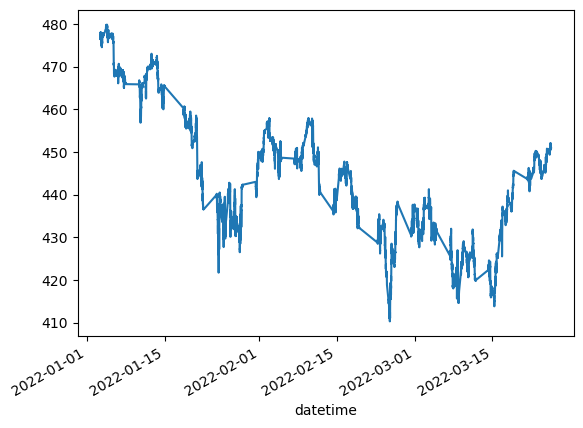

In [7]:
df.set_index('datetime')['close'].plot()

In [173]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']]
    
    lookback_data = lookback_data.div(lookback_data.iloc[-1,1]).values
    
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1
    
y = np.array(y).reshape(-1,1)
X = np.stack(X)

10965 ticks found


In [174]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(10939, 1)

In [175]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

growth_train = growth[:6000]
growth_test = growth[6000:]

with open('./StockPrediction/data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./StockPrediction/data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./StockPrediction/data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./StockPrediction/data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

What sort of resolution should I use? I.e. how much is one pixel equivalent to?

Things to consider:
- size of the CNN. The more pixels the more vram the CNN model will take up.
- variance of prices for the SPY. What sort of resolution do we start losing useful info? At the tens of pence, pence, or fractions of pence?

Based on the distribution below, We see 0.000003 or 0.0003% percentage change. So we need to aim for this sort of resolution?

Should we use one square to be 0.0001%?

In [176]:
# Plotting the distribution of differences between opens and closes
import tqdm
diffs = list()

for i in tqdm.tqdm(range(X_train.shape[0])):
    close_price = X_train[i,:,:][:,1]
    open_price = X_train[i,:,:][:,2]
    
    max_price = np.max(X_train[i,:,:][:,1])
    min_price = np.min(X_train[i,:,:][:,1])
    for close_price,open_price in zip(close_price.tolist(),open_price.tolist()):
        diffs.append(abs(close_price-open_price))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 135287.76it/s]


In [177]:
pd.Series(diffs).describe([0.001,0.01,0.05,0.06,0.1,0.25,0.5,0.75,0.99])

count    126000.000000
mean          0.000645
std           0.000814
min           0.000000
0.1%          0.000000
1%            0.000000
5%            0.000021
6%            0.000022
10%           0.000044
25%           0.000136
50%           0.000380
75%           0.000833
99%           0.003743
max           0.009762
dtype: float64

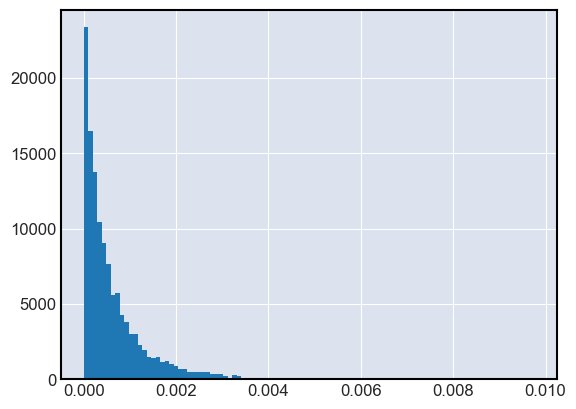

In [178]:
plt.hist(diffs,bins=100)
plt.show()

In [179]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank

def plot_time_series(series):
    np_img = convert_time_series_img(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

In [180]:
np.arange(-0.1,0.1,0.0001)

array([-0.1   , -0.0999, -0.0998, ...,  0.0997,  0.0998,  0.0999])

In [181]:
def convert_time_series_img2(series,lower_bound,upper_bound,resolution):
    
    volume_series = series[:,0].ravel()
    close_series = series[:,1].ravel()
    open_series = series[:,2].ravel()
    high_series = series[:,3].ravel()
    low_series = series[:,4].ravel()

    levels = [-np.inf]+np.arange(1-0.003,1+0.003,0.00002).tolist()+[np.inf]
    #levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)

    #Y_volume = pd.cut(volume_series,levels,labels=labels[::-1])
    Y_close = pd.cut(close_series,levels,labels=labels[::-1])
    Y_open = pd.cut(open_series,levels,labels=labels[::-1])
    Y_high = pd.cut(high_series,levels,labels=labels[::-1])
    Y_low = pd.cut(low_series,levels,labels=labels[::-1])

    blank = np.full( (n_levels,21,3),0)
    X = np.arange(0,len(close_series))
    for x,c,o,h,l in zip(X,Y_close,Y_open,Y_high,Y_low):
        if o>=c:
            for y in range(c,o):
                blank[y,x,0] = 60
                blank[y,x,1] = 240
                blank[y,x,2] = 60
        else:
            for y in range(o,c):
                blank[y,x,0] = 255
                blank[y,x,1] = 25
                blank[y,x,2] = 25
        
    return blank

def plot_time_series2(series):
    np_img = convert_time_series_img2(series,0.994,1.006,0.0001)
    fig, axes = plt.subplots(figsize=(50,5))
    axes.imshow(np_img)
    plt.savefig('times.png',dpi=300)
    plt.show()

In [189]:
X_train[19,:,:]

array([[ 9.09281199,  0.99995814,  0.99974882,  0.99995814,  0.99974882],
       [ 1.96759744,  0.99976975,  0.99983254,  0.99983254,  0.99976975],
       [ 8.62184452,  1.00004186,  0.99997907,  1.00004186,  0.99997907],
       [ 9.724955  ,  1.00033491,  1.00004186,  1.00039771,  1.00004186],
       [82.19324319,  1.00054423,  1.00041864,  1.00054423,  1.00039771],
       [ 6.05768828,  1.00048143,  1.00056516,  1.00062796,  1.00048143],
       [ 5.18273538,  1.00048143,  1.00050237,  1.0005233 ,  1.00048143],
       [ 5.75208272,  1.00066982,  1.00062796,  1.00066982,  1.00058609],
       [24.55938377,  1.00031398,  1.00071168,  1.00073262,  1.00020932],
       [ 7.50408172,  1.00054423,  1.00041864,  1.00056516,  1.00041864],
       [ 3.58353916,  1.00064889,  1.00054423,  1.00064889,  1.00048143],
       [ 3.6693599 ,  1.00043957,  1.00071168,  1.00071168,  1.00043957],
       [ 3.52283669,  1.00050237,  1.00043957,  1.00050237,  1.00035584],
       [ 2.6269519 ,  1.00056516,  1.0

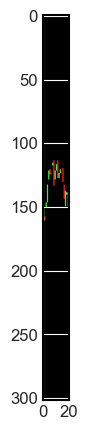

In [182]:
plot_time_series2(X_train[19,:,:])

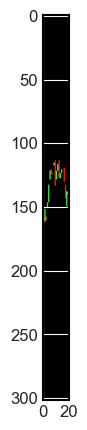

In [183]:
plot_time_series2(X_train[18,:,:])

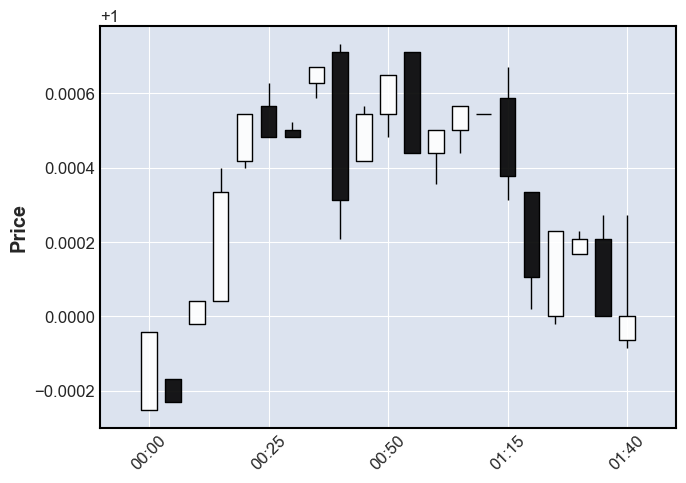

In [184]:
import mplfinance as mpf
mpf.plot(pd.DataFrame(X_train[19,:,:],columns=['Volume','Close','Open','High','Low'],
             index=pd.date_range('2020-01-01',periods=21,freq='5min')),type='candle')

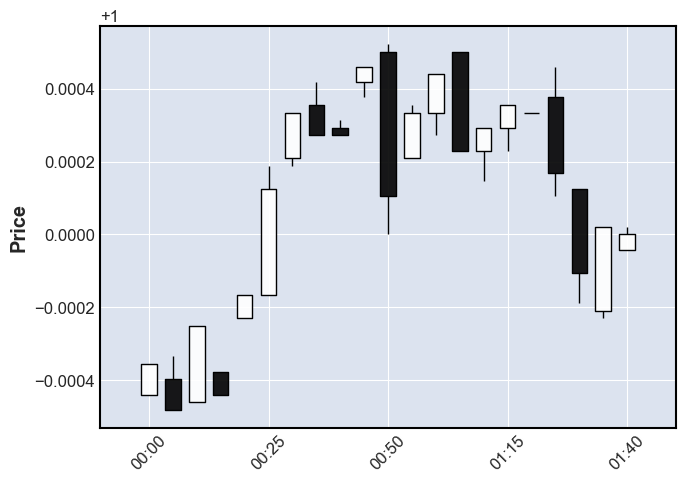

In [185]:
import mplfinance as mpf
mpf.plot(pd.DataFrame(X_train[17,:,:],columns=['Volume','Close','Open','High','Low'],
             index=pd.date_range('2020-01-01',periods=21,freq='5min')),type='candle')

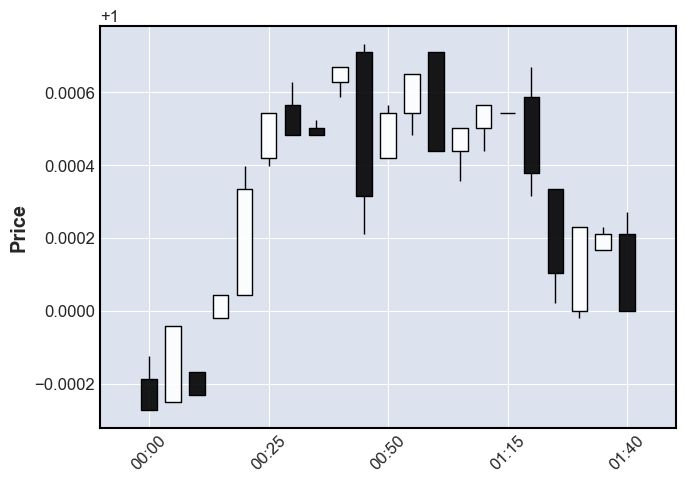

In [186]:
import mplfinance as mpf
mpf.plot(pd.DataFrame(X_train[18,:,:],columns=['Volume','Close','Open','High','Low'],
             index=pd.date_range('2020-01-01',periods=21,freq='5min')),type='candle')

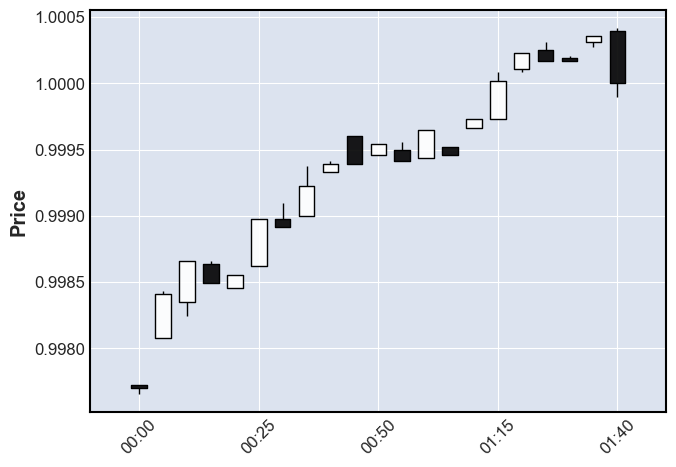

In [187]:
import mplfinance as mpf
mpf.plot(pd.DataFrame(X_train[7,:,:],columns=['Volume','Close','Open','High','Low'],
             index=pd.date_range('2020-01-01',periods=21,freq='5min')),type='candle')

In [188]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img2(X_train[x,:,:],0.99,1.01,0.0001).astype(np.uint8) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array_color.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [ ]:
img_train = np.stack([convert_time_series_img(X_train[x,:,:],0.99,1.01,0.0001) for x in range(len(X_train))])
img_test = np.stack([convert_time_series_img(X_test[x,:,:],0.99,1.01,0.0001) for x in range(len(X_test))])